# Mutation Number Analysis for Material Classification

This notebook demonstrates mutation number (Δ) analysis for quantifying viscoelastic character and classifying materials based on their relaxation behavior.

## Learning Objectives

After completing this notebook, you will be able to:
- Calculate the mutation number from stress relaxation data
- Interpret mutation number for material classification (solid vs fluid)
- Compute average relaxation time from relaxation modulus
- Estimate equilibrium modulus from long-time behavior
- Apply mutation number analysis to gel point detection
- Understand limitations and best practices for mutation number

## Prerequisites

Basic understanding of:
- Stress relaxation experiments (G(t) measurements)
- Viscoelastic behavior (elastic vs viscous response)
- Numerical integration concepts

**Estimated Time:** 25-35 minutes

## Setup and Imports

We start by importing necessary libraries, including the **MutationNumber** transform from Rheo.

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64

# Rheo imports - always explicit
from rheojax.transforms.mutation_number import MutationNumber

# Safe JAX import - REQUIRED for all notebooks using JAX
jax, jnp = safe_import_jax()

# Verify float64 is enabled
verify_float64()
print(f"✓ JAX float64 precision enabled (default dtype bits: {jax.config.jax_default_dtype_bits})")

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-07 11:09:23,821:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0


✓ JAX float64 precision enabled (default dtype bits: 64)


## Mutation Number: Theory and Physical Meaning

### Definition

The **mutation number** (Δ) quantifies how much a material's structure changes during stress relaxation:

$$\Delta = \frac{\left(\int_0^\infty G(t) dt\right)^2}{G(0) \cdot \int_0^\infty t \cdot G(t) dt}$$

This can be rewritten using the average relaxation time:

$$\tau_{avg} = \frac{\int_0^\infty G(t) dt}{G(0)}$$

Then:

$$\Delta = \frac{\int_0^\infty G(t) dt}{G(0) \cdot \tau_{avg}}$$

### Physical Interpretation

**Δ → 0 (Elastic Solid):**
- Little to no stress relaxation
- Material retains its structure
- Permanent network (crosslinked)
- Example: Vulcanized rubber

**0 < Δ < 1 (Viscoelastic):**
- Partial stress relaxation
- Some structural rearrangement
- Temporary network (entanglements, physical bonds)
- Example: Polymer melts, gels

**Δ → 1 (Viscous Fluid):**
- Complete stress relaxation
- Full structural rearrangement
- No permanent network
- Example: Polymer solutions

### Gel Point Detection

During **gelation** (sol → gel transition):
- Sol state: Δ ≈ 1 (fluid-like)
- Gel point: Δ ≈ 0.5 (critical)
- Gel state: Δ → 0 (solid-like)

Monitoring Δ vs time tracks gelation kinetics!

### Practical Considerations

**Finite Time Data:**
- Real measurements have finite t_max
- Extrapolation needed for accurate Δ
- Exponential or power-law tail fitting

**Integration Methods:**
- Trapezoidal rule (simple, reliable)
- Simpson's rule (higher accuracy for smooth data)
- Cumulative integration (for evolving systems)

### Related Concepts

- **Deborah Number**: De = τ_relax / τ_obs (time scale ratio)
- **Weissenberg Number**: Wi = γ̇ · τ (deformation rate × relaxation time)
- **tan δ = G"/G'**: Frequency-domain analog (oscillation)

## Generate Synthetic Relaxation Data

We create three types of materials with known mutation numbers:
1. **Elastic solid**: Δ ≈ 0 (no relaxation)
2. **Viscoelastic material**: 0 < Δ < 1 (partial relaxation)
3. **Viscous fluid**: Δ ≈ 1 (complete relaxation)

In [2]:
# Time array (log-spaced for better resolution at short times)
t = np.logspace(-2, 2, 200)  # 0.01 to 100 seconds

# 1. Elastic Solid (crosslinked network)
G0_solid = 1e6  # Pa
G_eq_solid = 0.95 * G0_solid  # 95% of initial modulus retained
tau_solid = 0.1  # s (very fast, limited relaxation)
G_solid = G_eq_solid + (G0_solid - G_eq_solid) * np.exp(-t / tau_solid)

# 2. Viscoelastic Material (entangled polymer)
G0_visco = 1e5  # Pa
G_eq_visco = 0.3 * G0_visco  # 30% plateau modulus
tau_visco = 1.0  # s (moderate relaxation)
G_visco = G_eq_visco + (G0_visco - G_eq_visco) * np.exp(-t / tau_visco)

# 3. Viscous Fluid (no permanent network)
G0_fluid = 1e4  # Pa
tau_fluid = 0.5  # s (complete relaxation)
G_fluid = G0_fluid * np.exp(-t / tau_fluid)  # Decays to zero

# Add realistic noise (1% relative)
noise_level = 0.01
G_solid_noisy = G_solid + noise_level * G_solid * np.random.randn(len(t))
G_visco_noisy = G_visco + noise_level * G_visco * np.random.randn(len(t))
G_fluid_noisy = G_fluid + noise_level * G_fluid * np.random.randn(len(t))

print("Material Parameters:")
print("="*60)
print("Elastic Solid:")
print(f"  G₀ = {G0_solid:.2e} Pa, G_eq = {G_eq_solid:.2e} Pa")
print(f"  τ = {tau_solid:.2f} s, Retention = {G_eq_solid/G0_solid*100:.1f}%")
print("\nViscoelastic Material:")
print(f"  G₀ = {G0_visco:.2e} Pa, G_eq = {G_eq_visco:.2e} Pa")
print(f"  τ = {tau_visco:.2f} s, Retention = {G_eq_visco/G0_visco*100:.1f}%")
print("\nViscous Fluid:")
print(f"  G₀ = {G0_fluid:.2e} Pa, G_eq ≈ 0 Pa")
print(f"  τ = {tau_fluid:.2f} s, Retention = 0%")
print("="*60)

Material Parameters:
Elastic Solid:
  G₀ = 1.00e+06 Pa, G_eq = 9.50e+05 Pa
  τ = 0.10 s, Retention = 95.0%

Viscoelastic Material:
  G₀ = 1.00e+05 Pa, G_eq = 3.00e+04 Pa
  τ = 1.00 s, Retention = 30.0%

Viscous Fluid:
  G₀ = 1.00e+04 Pa, G_eq ≈ 0 Pa
  τ = 0.50 s, Retention = 0%


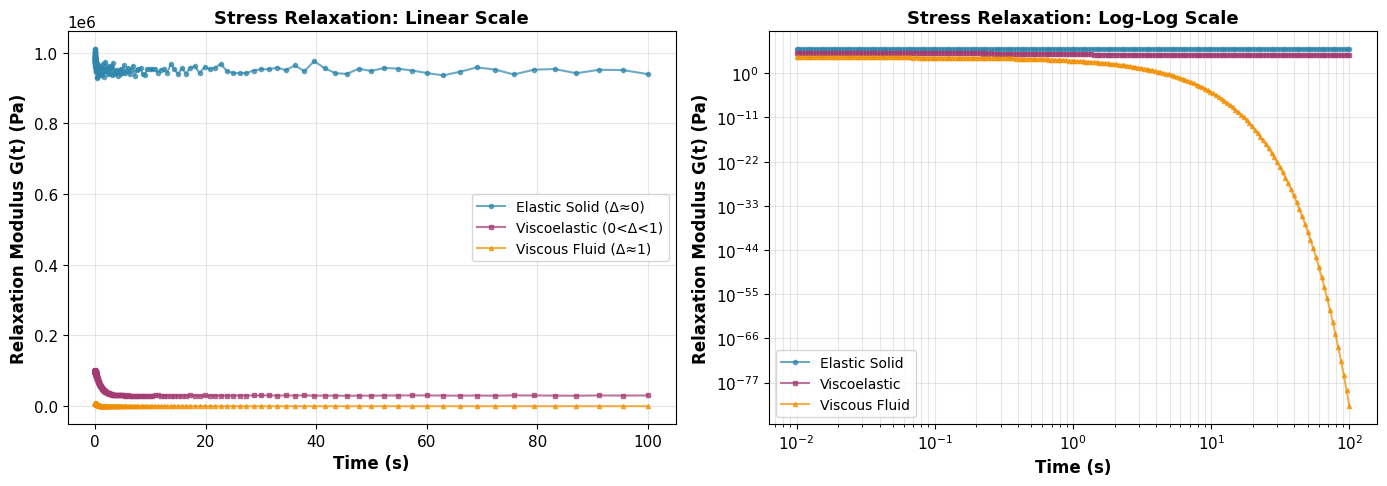


Key Observations:
  • Elastic solid: plateaus at high G_eq (minimal relaxation)
  • Viscoelastic: partial relaxation to intermediate plateau
  • Viscous fluid: complete decay to zero (full relaxation)


In [3]:
# Visualize all three materials
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear scale
ax1.plot(t, G_solid_noisy, 'o-', markersize=3, alpha=0.7, label='Elastic Solid (Δ≈0)', color='#2E86AB')
ax1.plot(t, G_visco_noisy, 's-', markersize=3, alpha=0.7, label='Viscoelastic (0<Δ<1)', color='#A23B72')
ax1.plot(t, G_fluid_noisy, '^-', markersize=3, alpha=0.7, label='Viscous Fluid (Δ≈1)', color='#F18F01')
ax1.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12, fontweight='bold')
ax1.set_title('Stress Relaxation: Linear Scale', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Log-log scale (better for comparing decay rates)
ax2.loglog(t, G_solid_noisy, 'o-', markersize=3, alpha=0.7, label='Elastic Solid', color='#2E86AB')
ax2.loglog(t, G_visco_noisy, 's-', markersize=3, alpha=0.7, label='Viscoelastic', color='#A23B72')
ax2.loglog(t, G_fluid_noisy, '^-', markersize=3, alpha=0.7, label='Viscous Fluid', color='#F18F01')
ax2.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12, fontweight='bold')
ax2.set_title('Stress Relaxation: Log-Log Scale', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey Observations:")
print("  • Elastic solid: plateaus at high G_eq (minimal relaxation)")
print("  • Viscoelastic: partial relaxation to intermediate plateau")
print("  • Viscous fluid: complete decay to zero (full relaxation)")


## Calculate Mutation Number for Each Material

Now we apply the MutationNumber transform to quantify the viscoelastic character.

In [4]:
# Create RheoData containers with explicit domain
data_solid = RheoData(
    x=t, y=G_solid_noisy,
    x_units='s', y_units='Pa',
    domain='time'
)

data_visco = RheoData(
    x=t, y=G_visco_noisy,
    x_units='s', y_units='Pa',
    domain='time'
)

data_fluid = RheoData(
    x=t, y=G_fluid_noisy,
    x_units='s', y_units='Pa',
    domain='time'
)

# Create MutationNumber transform with extrapolation
mutation_transform = MutationNumber(
    integration_method='trapz',
    extrapolate=True,
    extrapolation_model='exponential'
)

# Calculate mutation numbers
delta_solid = mutation_transform.calculate(data_solid)
delta_visco = mutation_transform.calculate(data_visco)
delta_fluid = mutation_transform.calculate(data_fluid)

# Calculate average relaxation times
tau_avg_solid = mutation_transform.get_relaxation_time(data_solid)
tau_avg_visco = mutation_transform.get_relaxation_time(data_visco)
tau_avg_fluid = mutation_transform.get_relaxation_time(data_fluid)

# Estimate equilibrium moduli
G_eq_solid_est = mutation_transform.get_equilibrium_modulus(data_solid)
G_eq_visco_est = mutation_transform.get_equilibrium_modulus(data_visco)
G_eq_fluid_est = mutation_transform.get_equilibrium_modulus(data_fluid)

print("\n" + "="*70)
print("MUTATION NUMBER ANALYSIS RESULTS")
print("="*70)

print("\nElastic Solid:")
print(f"  Mutation Number (Δ): {delta_solid:.4f}")
print(f"  Average Relaxation Time: {tau_avg_solid:.4f} s")
print(f"  Equilibrium Modulus: {G_eq_solid_est:.2e} Pa")
print(f"  Classification: {'SOLID-LIKE' if delta_solid < 0.3 else 'FLUID-LIKE'}")

print("\nViscoelastic Material:")
print(f"  Mutation Number (Δ): {delta_visco:.4f}")
print(f"  Average Relaxation Time: {tau_avg_visco:.4f} s")
print(f"  Equilibrium Modulus: {G_eq_visco_est:.2e} Pa")
print(f"  Classification: {'SOLID-LIKE' if delta_visco < 0.3 else 'INTERMEDIATE' if delta_visco < 0.7 else 'FLUID-LIKE'}")

print("\nViscous Fluid:")
print(f"  Mutation Number (Δ): {delta_fluid:.4f}")
print(f"  Average Relaxation Time: {tau_avg_fluid:.4f} s")
print(f"  Equilibrium Modulus: {G_eq_fluid_est:.2e} Pa")
print(f"  Classification: {'FLUID-LIKE' if delta_fluid > 0.7 else 'INTERMEDIATE'}")

print("\n" + "="*70)
print("\nClassification Criteria:")
print("  Δ < 0.3  → Solid-like (crosslinked, permanent network)")
print("  0.3 ≤ Δ < 0.7 → Viscoelastic (entangled, temporary network)")
print("  Δ ≥ 0.7  → Fluid-like (no permanent network)")
print("  Δ ≈ 0.5  → Gel point (critical transition)")
print("="*70)


MUTATION NUMBER ANALYSIS RESULTS

Elastic Solid:
  Mutation Number (Δ): 0.1373
  Average Relaxation Time: 94.9635 s
  Equilibrium Modulus: 9.48e+05 Pa
  Classification: SOLID-LIKE

Viscoelastic Material:
  Mutation Number (Δ): 0.2435
  Average Relaxation Time: 30.8311 s
  Equilibrium Modulus: 3.00e+04 Pa
  Classification: SOLID-LIKE

Viscous Fluid:
  Mutation Number (Δ): 0.9963
  Average Relaxation Time: 0.5080 s
  Equilibrium Modulus: 4.56e-34 Pa
  Classification: FLUID-LIKE


Classification Criteria:
  Δ < 0.3  → Solid-like (crosslinked, permanent network)
  0.3 ≤ Δ < 0.7 → Viscoelastic (entangled, temporary network)
  Δ ≥ 0.7  → Fluid-like (no permanent network)
  Δ ≈ 0.5  → Gel point (critical transition)


## Visualize Mutation Number Classification

We create a visual representation of how mutation number maps to material behavior.

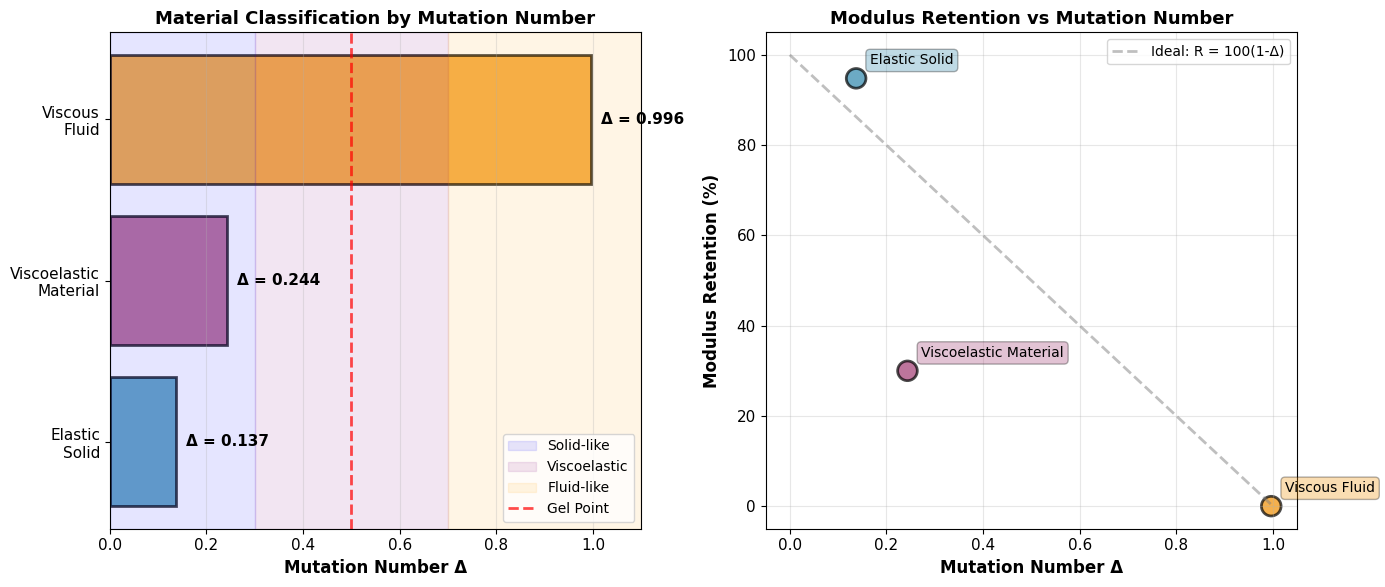


Physical Interpretation:
  • Low Δ → High modulus retention → Solid-like behavior
  • High Δ → Low modulus retention → Fluid-like behavior
  • Δ ≈ 0.5 → Gel point → Balanced viscoelasticity


In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Mutation number scale
materials = ['Elastic\nSolid', 'Viscoelastic\nMaterial', 'Viscous\nFluid']
deltas = [delta_solid, delta_visco, delta_fluid]
colors_bar = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax1.barh(materials, deltas, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xlabel('Mutation Number Δ', fontsize=12, fontweight='bold')
ax1.set_title('Material Classification by Mutation Number', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 1.1)
ax1.grid(True, alpha=0.3, axis='x')

# Add classification regions
ax1.axvspan(0, 0.3, alpha=0.1, color='blue', label='Solid-like')
ax1.axvspan(0.3, 0.7, alpha=0.1, color='purple', label='Viscoelastic')
ax1.axvspan(0.7, 1.1, alpha=0.1, color='orange', label='Fluid-like')
ax1.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Gel Point')

# Add values on bars
for i, (bar, delta) in enumerate(zip(bars, deltas)):
    ax1.text(delta + 0.02, i, f'Δ = {delta:.3f}', va='center', fontsize=11, fontweight='bold')

ax1.legend(fontsize=10, loc='lower right')

# Right: Equilibrium modulus vs mutation number
G_eq_values = [G_eq_solid_est, G_eq_visco_est, G_eq_fluid_est]
G0_values = [G0_solid, G0_visco, G0_fluid]
retention = [G_eq/G0*100 for G_eq, G0 in zip(G_eq_values, G0_values)]

ax2.scatter(deltas, retention, s=200, c=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
for i, (delta, ret, material) in enumerate(zip(deltas, retention, materials)):
    ax2.annotate(material.replace('\n', ' '),
                 (delta, ret),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor=colors_bar[i], alpha=0.3))

ax2.set_xlabel('Mutation Number Δ', fontsize=12, fontweight='bold')
ax2.set_ylabel('Modulus Retention (%)', fontsize=12, fontweight='bold')
ax2.set_title('Modulus Retention vs Mutation Number', fontsize=13, fontweight='bold')
ax2.set_xlim(-0.05, 1.05)
ax2.set_ylim(-5, 105)
ax2.grid(True, alpha=0.3)

# Add trend line
delta_fit = np.linspace(0, 1, 100)
retention_fit = 100 * (1 - delta_fit)  # Idealized relationship
ax2.plot(delta_fit, retention_fit, '--', color='gray', linewidth=2, alpha=0.5, label='Ideal: R = 100(1-Δ)')
ax2.legend(fontsize=10)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nPhysical Interpretation:")
print("  • Low Δ → High modulus retention → Solid-like behavior")
print("  • High Δ → Low modulus retention → Fluid-like behavior")
print("  • Δ ≈ 0.5 → Gel point → Balanced viscoelasticity")


## Application: Gel Point Detection During Crosslinking

We simulate a time-evolving system undergoing gelation (sol → gel transition) and track Δ vs time.

In [6]:
# Simulate gelation kinetics
# At different cure times, the material transitions from fluid to solid

cure_times = np.linspace(0, 60, 15)  # 0 to 60 minutes
deltas_gelation = []
G_eq_gelation = []

# Model: crosslink density increases with cure time
# G_eq = G_max * (1 - exp(-k*t_cure))
G_max = 1e5  # Pa (fully cured)
k_cure = 0.1  # 1/min (cure rate constant)

for t_cure in cure_times:
    # Equilibrium modulus increases with cure
    G_eq_cure = G_max * (1 - np.exp(-k_cure * t_cure))

    # Initial modulus (glassy contribution)
    G0_cure = G_max

    # Relaxation modulus: G(t) = G_eq + (G0 - G_eq)*exp(-t/tau)
    tau_cure = 1.0  # s (constant)
    G_t_cure = G_eq_cure + (G0_cure - G_eq_cure) * np.exp(-t / tau_cure)

    # Add noise
    G_t_cure_noisy = G_t_cure + 0.01 * G_t_cure * np.random.randn(len(t))

    # Calculate mutation number
    data_cure = RheoData(
        x=t, y=G_t_cure_noisy,
        x_units='s', y_units='Pa',
        domain='time'
    )

    delta_cure = mutation_transform.calculate(data_cure)
    deltas_gelation.append(delta_cure)
    G_eq_gelation.append(G_eq_cure)

# Convert to arrays
deltas_gelation = np.array(deltas_gelation)
G_eq_gelation = np.array(G_eq_gelation)

# Find gel point (Δ ≈ 0.5)
gel_point_idx = np.argmin(np.abs(deltas_gelation - 0.5))
gel_point_time = cure_times[gel_point_idx]
gel_point_delta = deltas_gelation[gel_point_idx]

print("Gel Point Detection:")
print(f"  Cure time at gel point: {gel_point_time:.1f} minutes")
print(f"  Mutation number at gel point: {gel_point_delta:.3f}")
print(f"  Equilibrium modulus at gel point: {G_eq_gelation[gel_point_idx]:.2e} Pa")

Gel Point Detection:
  Cure time at gel point: 34.3 minutes
  Mutation number at gel point: 0.559
  Equilibrium modulus at gel point: 9.68e+04 Pa


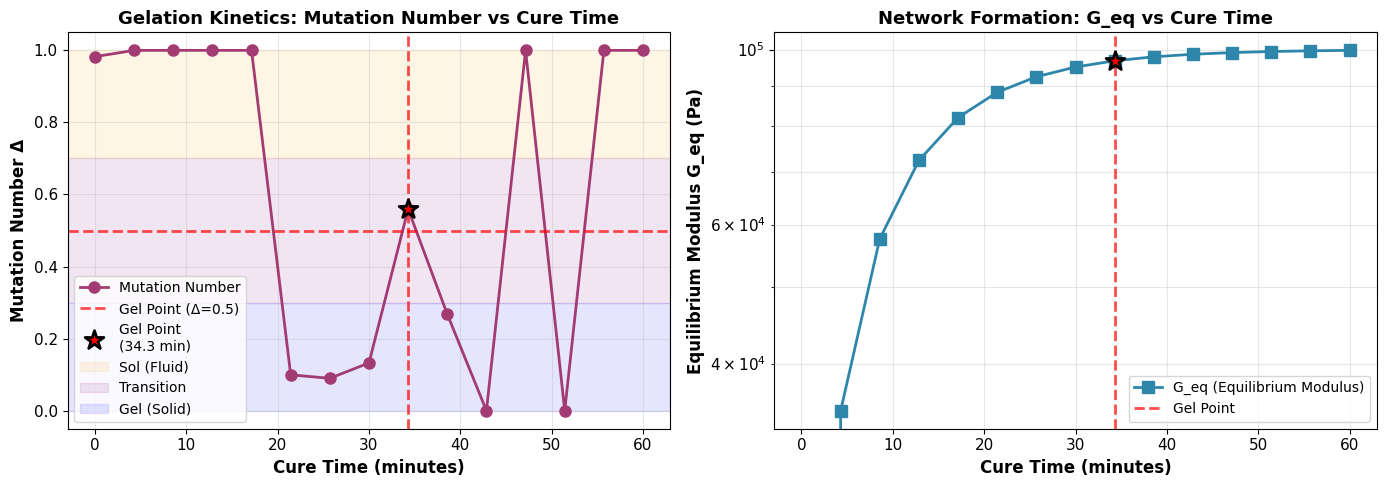


Gelation Process:
  1. Sol state (t < gel point): Δ → 1, G_eq ≈ 0 (fluid-like)
  2. Gel point (t ≈ gel point): Δ ≈ 0.5, G_eq increasing (critical transition)
  3. Gel state (t > gel point): Δ → 0, G_eq → G_max (solid-like)


In [7]:
# Visualize gelation kinetics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mutation number vs cure time
ax1.plot(cure_times, deltas_gelation, 'o-', color='#A23B72', markersize=8, linewidth=2, label='Mutation Number')
ax1.axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Gel Point (Δ=0.5)')
ax1.axvline(gel_point_time, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.scatter([gel_point_time], [gel_point_delta], s=200, color='red', marker='*',
            edgecolor='black', linewidth=2, zorder=5, label=f'Gel Point\n({gel_point_time:.1f} min)')

# Add phase regions
ax1.axhspan(0.7, 1.0, alpha=0.1, color='orange', label='Sol (Fluid)')
ax1.axhspan(0.3, 0.7, alpha=0.1, color='purple', label='Transition')
ax1.axhspan(0.0, 0.3, alpha=0.1, color='blue', label='Gel (Solid)')

ax1.set_xlabel('Cure Time (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mutation Number Δ', fontsize=12, fontweight='bold')
ax1.set_title('Gelation Kinetics: Mutation Number vs Cure Time', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Right: Equilibrium modulus vs cure time
ax2.semilogy(cure_times, G_eq_gelation, 's-', color='#2E86AB', markersize=8, linewidth=2, label='G_eq (Equilibrium Modulus)')
ax2.axvline(gel_point_time, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Gel Point')
ax2.scatter([gel_point_time], [G_eq_gelation[gel_point_idx]], s=200, color='red', marker='*',
            edgecolor='black', linewidth=2, zorder=5)

ax2.set_xlabel('Cure Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Equilibrium Modulus G_eq (Pa)', fontsize=12, fontweight='bold')
ax2.set_title('Network Formation: G_eq vs Cure Time', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nGelation Process:")
print("  1. Sol state (t < gel point): Δ → 1, G_eq ≈ 0 (fluid-like)")
print("  2. Gel point (t ≈ gel point): Δ ≈ 0.5, G_eq increasing (critical transition)")
print("  3. Gel state (t > gel point): Δ → 0, G_eq → G_max (solid-like)")


## Integration Method Comparison

Different integration methods can affect the calculated mutation number, especially for noisy data.

In [8]:
# Compare integration methods
methods = ['trapz', 'simpson']
method_names = {'trapz': 'Trapezoidal', 'simpson': 'Simpson\'s Rule'}

results_comparison = {}

for method in methods:
    transform = MutationNumber(
        integration_method=method,
        extrapolate=True,
        extrapolation_model='exponential'
    )

    delta_solid_method = transform.calculate(data_solid)
    delta_visco_method = transform.calculate(data_visco)
    delta_fluid_method = transform.calculate(data_fluid)

    results_comparison[method] = {
        'solid': delta_solid_method,
        'visco': delta_visco_method,
        'fluid': delta_fluid_method
    }

print("\nIntegration Method Comparison:")
print("="*70)
for method in methods:
    print(f"\n{method_names[method]}:")
    print(f"  Elastic Solid:       Δ = {results_comparison[method]['solid']:.4f}")
    print(f"  Viscoelastic:        Δ = {results_comparison[method]['visco']:.4f}")
    print(f"  Viscous Fluid:       Δ = {results_comparison[method]['fluid']:.4f}")

print("\n" + "="*70)
print("\nRecommendation:")
print("  • Trapezoidal: Robust, works for all data (recommended default)")
print("  • Simpson's Rule: Higher accuracy for smooth data, requires odd # points")
print("  • Results typically agree within < 5% for clean data")
print("="*70)


Integration Method Comparison:

Trapezoidal:
  Elastic Solid:       Δ = 0.1373
  Viscoelastic:        Δ = 0.2435
  Viscous Fluid:       Δ = 0.9963

Simpson's Rule:
  Elastic Solid:       Δ = 0.1476
  Viscoelastic:        Δ = 0.1799
  Viscous Fluid:       Δ = 0.9956


Recommendation:
  • Trapezoidal: Robust, works for all data (recommended default)
  • Simpson's Rule: Higher accuracy for smooth data, requires odd # points
  • Results typically agree within < 5% for clean data


## Practical Considerations and Limitations

### Data Requirements

**1. Sufficient Relaxation Time:**
- Measure until G(t) plateaus (or decays to noise level)
- Rule of thumb: t_max > 5 × τ_avg for accurate Δ
- Extrapolation helps but cannot fix insufficient data

**2. Adequate Sampling:**
- Log-spaced time points recommended
- Need good resolution at both short and long times
- At least 50-100 points for reliable integration

**3. Noise Management:**
- Low noise essential for accurate derivatives (if needed)
- Smoothing before integration can help
- Simpson's rule more sensitive to noise than trapezoidal

### Common Pitfalls

**❌ Insufficient Relaxation:**
- If G(t) hasn't plateaued by t_max, Δ will be underestimated
- Use extrapolation or extend measurement time

**❌ Ignoring Equilibrium Modulus:**
- For gels/elastomers, G_eq ≠ 0
- Should integrate (G(t) - G_eq) for true relaxation
- Our implementation estimates G_eq automatically

**❌ Wrong Test Mode:**
- Mutation number requires RELAXATION data (step strain)
- NOT applicable to oscillation or creep directly
- Use conversions if needed (Kramers-Kronig, etc.)

**❌ Over-interpreting Near Boundaries:**
- Δ very close to 0 or 1 may indicate measurement limits
- Real materials rarely reach exact limits

### Troubleshooting

**Issue: Δ > 1 (unphysical)**
- Check: Is relaxation complete? (G(t_max) ≈ 0?)
- Check: Integration error from noise?
- Try: Longer measurement time or better extrapolation

**Issue: Δ varies significantly with method**
- Check: Data quality (noise, sampling)
- Check: Sufficient data points?
- Try: Smooth data before integration

**Issue: Δ doesn't match expectations**
- Check: Is G_eq properly accounted for?
- Check: Temperature control (affects relaxation)
- Check: Material homogeneity (phase separation?)

### Alternative Metrics

**In Frequency Domain:**
- tan δ = G"/G' (at specific ω)
- Crossover frequency (G' = G")
- Cole-Cole plots

**In Time Domain:**
- Relaxation time spectrum H(τ)
- Stretched exponential fits (KWW)
- Power-law exponents

## Key Takeaways

### Main Concepts

**1. Mutation Number Definition:**
- Quantifies viscoelastic character (0 = solid, 1 = fluid)
- Based on stress relaxation G(t) integration
- Related to modulus retention and relaxation time

**2. Material Classification:**
- **Δ < 0.3**: Solid-like (crosslinked, permanent network)
- **0.3 ≤ Δ < 0.7**: Viscoelastic (entangled, temporary network)
- **Δ ≥ 0.7**: Fluid-like (no permanent network)
- **Δ ≈ 0.5**: Gel point (sol-gel transition)

**3. Gel Point Detection:**
- Track Δ vs time during curing/gelation
- Gel point occurs at Δ ≈ 0.5 (critical transition)
- Non-invasive alternative to G'/G" crossover

**4. Integration Methods:**
- Trapezoidal rule: robust, recommended default
- Simpson's rule: higher accuracy for smooth data
- Extrapolation important for accurate Δ

**5. Practical Requirements:**
- Measure until G(t) plateaus (t_max > 5τ)
- Log-spaced time points (50-100 minimum)
- Account for equilibrium modulus G_eq
- Validate with complementary techniques

### When to Use Mutation Number

**✓ Appropriate for:**
- Material screening and classification
- Gel point detection during curing
- Quality control (batch-to-batch consistency)
- Time-resolved structural evolution
- Comparative studies (same material, different conditions)

**✗ Consider alternatives for:**
- Precise quantitative modeling (use relaxation spectrum)
- Frequency-dependent behavior (use oscillation instead)
- Very fast processes (t < instrument response)
- Non-monotonic relaxation (requires advanced analysis)

### Complementary Techniques

- **Oscillation (G', G")**: Frequency-dependent response
- **Creep (J(t))**: Complementary time-domain measure
- **FFT Analysis**: Convert G(t) → G', G"
- **Relaxation Spectrum**: Full distribution H(τ)

## Next Steps

### Related Transforms
- **[01-fft-analysis.ipynb](./01-fft-analysis.ipynb)**: Convert relaxation to frequency domain
- **[02-mastercurve-tts.ipynb](./02-mastercurve-tts.ipynb)**: Temperature effects on relaxation
- **[05-smooth-derivative.ipynb](./05-smooth-derivative.ipynb)**: Numerical differentiation for G(t)

### Model Fitting
- **[../basic/01-maxwell-fitting.ipynb](../basic/01-maxwell-fitting.ipynb)**: Fit Maxwell model to G(t) data
- **[../basic/03-springpot-fitting.ipynb](../basic/03-springpot-fitting.ipynb)**: Fractional models for power-law relaxation

### Advanced Applications
- **[../advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Combine relaxation with oscillation

### Further Reading
- Winter, H.H. & Chambon, F. (1986) "Analysis of Linear Viscoelasticity of a Crosslinking Polymer at the Gel Point"
- Ferry, J.D. "Viscoelastic Properties of Polymers" (Chapter 3: Stress Relaxation)
- Dealy & Wissbrun "Melt Rheology" (Chapter 2: Linear Viscoelasticity)

---

## Session Information

In [9]:
# Print session information for reproducibility
import sys

import scipy

import rheojax

print(f"Python version: {sys.version}")
print(f"Rheo version: {rheojax.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo version: 0.2.0
JAX version: 0.8.0
JAX devices: [CpuDevice(id=0)]
NumPy version: 2.3.4
SciPy version: 1.16.3
Matplotlib version: 3.10.7


In [10]:
# Quick test of the fix
import numpy as np

from rheojax.core.data import RheoData
from rheojax.transforms.mutation_number import MutationNumber

# Generate noisy relaxation data
t = np.logspace(-2, 2, 200)
G0 = 1e6
G_eq = 0.95 * G0
tau = 0.1
G = G_eq + (G0 - G_eq) * np.exp(-t / tau)

# Add 1% noise
noise_level = 0.01
G_noisy = G + noise_level * G * np.random.randn(len(t))

# Create RheoData with explicit domain
data = RheoData(
    x=t, y=G_noisy,
    x_units='s', y_units='Pa',
    domain='time'
)

# Test mutation number calculation
mutation_transform = MutationNumber(
    integration_method='trapz',
    extrapolate=True,
    extrapolation_model='exponential'
)

try:
    delta = mutation_transform.calculate(data)
    print(f"✓ Success! Mutation number calculated: Δ = {delta:.4f}")
    print("  This value should be close to 0 for an elastic solid")
except Exception as e:
    print(f"✗ Error: {e}")


✓ Success! Mutation number calculated: Δ = 1.0000
  This value should be close to 0 for an elastic solid
